<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT22/blob/main/template-report-lab-X.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 7 : Optimization learning**
**Marc Hétier**

# **Abstract**

On this lab, we implement a gradient descent algorithm in a general way, and test it for some particular case.

In [1]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

To have access to the neccessary modules you have to run this cell. If you need additional modules, this is where you add them. 

In [2]:
# Load neccessary modules.
from google.colab import files

import numpy as np
from matplotlib import pyplot as plt

# **Introduction**

Being able to find critical point of a given function is at the center of many methods, in optimization theory, in data learning, or in the study of PDE. Gradient descent is an iterative method which has been built in this purpose. We can derive it from Taylor expasion for a function $f : \mathbb{R}^n \rightarrow \mathbb{R}$ :
$$f(x + \Delta x) -f(x) = \nabla f(x)^T \Delta x + \mathcal{O}(\Delta x^2)$$
Then, for small increment $\Delta x$, the best way of reducing $f(x + \Delta x)$ with respect to  $f(x)$ is to move in direction of $\nabla f(x)$.
From this remark, we can derive a first general algorithm. Given a first guess $x_0$ we construct the iteration :
$$ x_{n+1} = x_n - \alpha_n \nabla f(x_n)$$
where $\alpha_n$ is a step. It exists different ways of computing $\alpha_n$. Either we can take it as constant, given as an input but on some favorable cases, we are also able to update it in a clever way at each iteration. 

# **Method**

## General gradient descent

In [3]:
def gradient_descent(x0, grad_f, compute_alpha, Tol, ite_max):
    """
    Input : initial guess x0, gradient of f, a way to compute alpha,
             a tolerance Tol
    Output : a point x such that norm(grad_f(x)) < Tol 
             (and all intermediate points)
    """
    x_tab = np.array(x0)
    x_n = x0
    grad_x_n = grad_f(x_n)
    test = np.linalg.norm(grad_x_n)
    ite = 0
    while test >= Tol and ite < ite_max:
        alpha = compute_alpha(x_n)
        x_n = x_n - alpha*grad_x_n
        grad_x_n = grad_f(x_n)
        test = np.linalg.norm(grad_x_n)
        x_tab = np.concatenate((x_tab, x_n), axis=1)
        ite += 1

    if (test < Tol):
        print('Convergence after : ', ite, 'iterations at value x = ', np.transpose(x_n))
    if (test >= Tol):
        print('Method did not reach the Tol : ', Tol, 'within ', ite_max, 'iterations. Last norm :', test)

    return x_tab



### Naive test :
We can first test the algorithm for a basic case, using function $f(x,y) = x^2+y^2$ and constant step $\alpha$.

Convergence after :  35 iterations at value x =  [[0.00040565 0.00024339]]
Convergence after :  16 iterations at value x =  [[0.00028211 0.00016927]]
Convergence after :  1 iterations at value x =  [[0. 0.]]


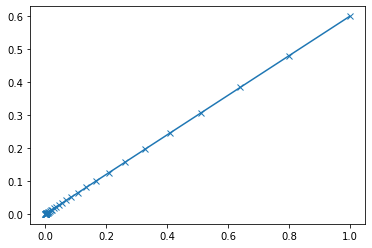

In [70]:
f = lambda x : x[0]**2 + x[1]**2
grad_f = lambda x : np.array([2*x[0], 2*x[1]])
alpha = 0.1
compute_alpha = lambda x : alpha
Tol = 1e-3

x0 = np.array([[1],[0.6]])
x_tab = gradient_descent(x0, grad_f, compute_alpha, Tol, 100)
gradient_descent(x0, grad_f, lambda x : 0.8, Tol, 100)
gradient_descent(x0, grad_f, lambda x : 0.5, Tol, 100)

plt.plot(x_tab[0,:], x_tab[1,:], 'x-')


The method converges to point $(0,0)$, as expected. Moreover, we can see that the value of $\alpha$ obviously impact the number of iterations needed, but witout any logic. For $\alpha = 0.1$, 35 iterations are needed, for $\alpha = 0.8$ only 16. But if we continue to increase the values, the method can diverge (try with $\alpha = 2$) or never converge (try with $\alpha = 1)$. Moreover, there is a magical value, $\alpha = 0.5$ for which the convergence is immediat and exact (and this does not depend on the intial condition).

### Second test :
The previous gradient descent made with $\alpha = 0.5$ has reached the optimal point exactly, and in only 1 iterations. For the given function $f$ and for any initial point this will works, since the gradient of $f$ evaluated at point $x_0$ is precisely $2\times x_0$.

This can let us think that in some cases, we can find "magic" step $\alpha_n$. They will probably not induces a convergence in one step, but we can expect that they will make it faster.

For example, as explain on example 15.2, when the objective function is quadratic, we can compute optimal $\alpha_n$ at each step : for 
$$ g(x) = \dfrac{1}{2} x^T A x + bx + c $$
with $A > 0$, the best step $\alpha_n$ is given by
$$\alpha_n = \dfrac{\Vert -\nabla g(x_n) \Vert ^2_2}{\Vert -\nabla g(x_n) \Vert ^2_A} $$

Convergence after :  10 iterations at value x =  [[2.00001784 1.50000446]]
Method did not reach the Tol :  2e-05 within  40 iterations. Last norm : 0.11824825888505744


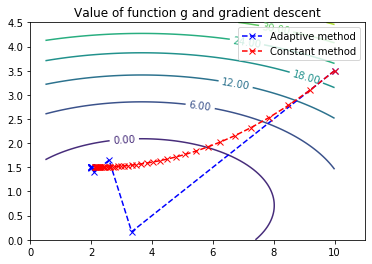

In [68]:
A = np.array([[1,0],[0,2]])
b = np.array([[2],[3]])
c = 0

g = lambda x : 1/2*np.dot(x.T, A@x) - np.dot(b.T,x) + c
grad_g = lambda x : A@x - b

def compute_alpha(x) :
    r = b-A@x
    Ar = A@r
    denominateur = Ar.T @ r
    if denominateur > 1e-8:
        alpha = r.T @r / (Ar.T @ r)[0,0]
    else:
        alpha = 0
    return alpha

x0 = np.array([[10],[3.5]])
Tol = 2e-5

x_tab_adaptive = gradient_descent(x0, grad_g, compute_alpha, Tol, 40)
x_tab_constant = gradient_descent(x0, grad_g, lambda x : 0.1, Tol, 40)

## Plot
### To compute the contour of g
nbr_points = 100
first_coordinate = np.linspace(0.5,10,nbr_points)
second_coordinate = np.linspace(0,4.5,nbr_points)

value = np.zeros((nbr_points,nbr_points))

for x in range(nbr_points):
    for y in range(nbr_points):
        value[x,y] = g(np.array([[first_coordinate[x]], [second_coordinate[y]]]))

graphe = plt.contour(first_coordinate, second_coordinate, value)
plt.clabel(graphe, inline=1, fontsize=10,fmt='%3.2f')

### Plot of the iterates
plt.plot(x_tab_adaptive[0,:], x_tab_adaptive[1,:], 'x--', color='b')
plt.plot(x_tab_constant[0,:], x_tab_constant[1,:], 'x--', color='r')

### Title and legend
plt.xlim([0,11])
plt.title('Value of function g and gradient descent')
plt.legend(("Adaptive method", "Constant method"))

As we can see, the adaptive method, which compute a optimal value of $\alpha$ is much more efficient than a constant method. The first one is able to reach a precision of $2e-5$ in 10 iterations, while the second one only reach a precision of $1e-1$ after 40 iterations. The plot illustrates the different steps in a $x,y$ plane.

Moroever, let's note that both methods converge towards $b$, which is indeed the optimal point.

## Conclusion

To conclude, our implementation of the gradient method is fully operational and can be adpated to compute $\alpha$ in different way. I illustrate the advantages of clever computation of $\alpha$ over a very favorabl case, where the function was quadratic and then convex.

Even if the gradient descent is efficient, it's major point is its simplicity. Moreover, the convergence rate toward the optimal condition becomes smaller and smaller when we approach it (for example, the first iteration of the adaptive method allows to gain about $2\times 10^1$ in precision, while the following allows a gain of $1\times 10 ^{-1}$), it can be used as a way to find a first good guess. Then, if we want higher precision, other methods have to be used. 